In [1]:
import os
import json
import random

def balance_dataset(benign_path, malware_path, output_file):
    benign_reports = []
    malware_reports = []

    # Load benign reports
    for filename in os.listdir(benign_path):
        if filename.endswith('_report.json'):
            file_path = os.path.join(benign_path, filename)
            benign_reports.append((file_path, os.path.getsize(file_path)))

    # Load malware reports
    for filename in os.listdir(malware_path):
        if filename.endswith('_report.json'):
            file_path = os.path.join(malware_path, filename)
            malware_reports.append((file_path, os.path.getsize(file_path)))

    # Sort malware reports by size (smallest to largest)
    malware_reports.sort(key=lambda x: x[1])

    # Keep only the number of malware reports that matches benign reports
    malware_reports = malware_reports[:len(benign_reports)]

    # Combine and shuffle all reports
    all_reports = benign_reports + malware_reports
    random.shuffle(all_reports)

    # Prepare the output data
    output_data = {
        "benign_count": len(benign_reports),
        "malware_count": len(malware_reports),
        "total_count": len(all_reports),
        "files_to_process": [report[0] for report in all_reports]
    }

    # Save the output to a JSON file
    with open(output_file, 'w') as f:
        json.dump(output_data, f, indent=2)

    print(f"Dataset balanced. Total reports: {len(all_reports)}")
    print(f"Benign reports: {len(benign_reports)}")
    print(f"Malware reports: {len(malware_reports)}")
    print(f"Output saved to: {output_file}")

if __name__ == "__main__":
    benign_path = "/kaggle/input/iotguard/Reports/benign_reports"
    malware_path = "/kaggle/input/iotguard/Reports/malware_reports"
    output_file = "/kaggle/working/balanced_dataset.json"

    balance_dataset(benign_path, malware_path, output_file)

Dataset balanced. Total reports: 1048
Benign reports: 524
Malware reports: 524
Output saved to: /kaggle/working/balanced_dataset.json


In [7]:
import json
import numpy as np
import logging
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from collections import Counter
from tqdm import tqdm
import pickle

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def load_and_preprocess_data(file_path):
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        return extract_features(data)
    except Exception as e:
        logger.error(f"Error processing file {file_path}: {str(e)}")
        return None

def extract_features(report):
    features = {}
    
    # Static Analysis Features
    static = report.get('static_analysis', {})
    features['file_class'] = 1 if static.get('elf_header', {}).get('Class') == 'ELF32' else 0
    features['data_encoding'] = 1 if static.get('elf_header', {}).get('Data') == "2's complement, little endian" else 0
    features['os_abi'] = static.get('elf_header', {}).get('OS/ABI', 'Unknown')
    features['file_type'] = static.get('elf_header', {}).get('Type', 'Unknown')
    
    sections = static.get('section_headers', [])
    features['num_sections'] = len(sections)
    features['.text_present'] = any('.text' in s for s in sections)
    features['.data_present'] = any('.data' in s for s in sections)
    features['.bss_present'] = any('.bss' in s for s in sections)
    
    # Dynamic Analysis Features
    strace = report.get('dynamic_analysis', {}).get('strace', {}).get('syscalls', [])
    syscall_counts = Counter(s['syscall'] for s in strace)
    features['total_syscalls'] = len(strace)
    for syscall in ['execve', 'fork', 'clone', 'connect']:
        features[f'{syscall}_count'] = syscall_counts.get(syscall, 0)
    
    ltrace = report.get('dynamic_analysis', {}).get('ltrace_summary', {}).get('call_frequencies', {})
    features['total_func_calls'] = sum(ltrace.values())
    for func in ['malloc', 'free', 'connect', 'socket']:
        features[f'{func}_count'] = ltrace.get(func, 0)
    
    # Network Activity Features
    network = report.get('network_activity', {}).get('network_activity', [])
    ip_addresses = set()
    ports = set()
    for packet in network:
        ip = packet.get('layers', {}).get('ip', {})
        tcp = packet.get('layers', {}).get('tcp', {})
        ip_addresses.add(ip.get('ip.src'))
        ip_addresses.add(ip.get('ip.dst'))
        ports.add(tcp.get('tcp.srcport'))
        ports.add(tcp.get('tcp.dstport'))
    
    features['unique_ips'] = len(ip_addresses)
    features['unique_ports'] = len(ports)
    features['telnet_activity'] = any(p == '23' for p in ports)
    features['total_packets'] = len(network)
    
    # Metadata Features
    metadata = report.get('metadata', {})
    features['file_size'] = int(metadata.get('file_size', 0))
    features['creation_time'] = float(metadata.get('created', 0))
    features['modification_time'] = float(metadata.get('last_modified', 0))
    
    return features

def preprocess_features(features_list):
    numeric_features = ['total_syscalls', 'total_func_calls', 'unique_ips', 'unique_ports', 'total_packets', 'file_size']
    categorical_features = ['os_abi', 'file_type']
    
    numeric_data = np.array([[f[nf] for nf in numeric_features] for f in features_list])
    categorical_data = np.array([[f[cf] for cf in categorical_features] for f in features_list])
    
    scaler = StandardScaler()
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    
    normalized_numeric = scaler.fit_transform(numeric_data)
    encoded_categorical = encoder.fit_transform(categorical_data)
    
    binary_features = ['file_class', 'data_encoding', '.text_present', '.data_present', '.bss_present', 'telnet_activity']
    binary_data = np.array([[f[bf] for bf in binary_features] for f in features_list])
    
    return np.hstack([normalized_numeric, encoded_categorical, binary_data])

def save_checkpoint(processed_files, features_list, checkpoint_file):
    with open(checkpoint_file, 'wb') as f:
        pickle.dump({'processed_files': processed_files, 'features_list': features_list}, f)
    logger.info(f"Checkpoint saved to {checkpoint_file}")

def load_checkpoint(checkpoint_file):
    if os.path.exists(checkpoint_file):
        with open(checkpoint_file, 'rb') as f:
            checkpoint = pickle.load(f)
        logger.info(f"Checkpoint loaded from {checkpoint_file}")
        return checkpoint['processed_files'], checkpoint['features_list']
    return set(), []

def process_dataset(file_paths, checkpoint_file='checkpoint.pkl', checkpoint_interval=100):
    processed_files, features_list = load_checkpoint(checkpoint_file)
    
    try:
        for file_path in tqdm(file_paths, desc="Processing files"):
            if file_path in processed_files:
                continue
            
            features = load_and_preprocess_data(file_path)
            if features is not None:
                features_list.append(features)
                processed_files.add(file_path)
            
            if len(processed_files) % checkpoint_interval == 0:
                save_checkpoint(processed_files, features_list, checkpoint_file)
        
        # Final save
        save_checkpoint(processed_files, features_list, checkpoint_file)
    except KeyboardInterrupt:
        logger.info("Processing interrupted. Progress saved.")
        save_checkpoint(processed_files, features_list, checkpoint_file)
    
    return features_list

# Usage
if __name__ == "__main__":
    logger.info("Starting feature extraction process")
    
    with open("/kaggle/working/balanced_dataset.json", 'r') as f:
        balanced_data = json.load(f)

    file_paths = balanced_data['files_to_process']
    features_list = process_dataset(file_paths)
    
    logger.info("Feature extraction completed. Preprocessing features.")
    X = preprocess_features(features_list)
    y = np.array([1 if 'malware' in fp else 0 for fp in file_paths])

    logger.info(f"Feature matrix shape: {X.shape}")
    logger.info(f"Number of malware samples: {sum(y)}")
    logger.info(f"Number of benign samples: {len(y) - sum(y)}")

    # Save final results
    np.save('/kaggle/working/feature_matrix.npy', X)
    np.save('/kaggle/working/labels.npy', y)
    logger.info("Feature matrix and labels saved.")

Processing files: 100%|██████████| 1048/1048 [00:00<00:00, 730413.86it/s]
/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [12]:
import numpy as np
import pandas as pd

# Load the data
X = np.load('/kaggle/working/feature_matrix.npy')
y = np.load('/kaggle/working/labels.npy')

# Define all 19 feature columns correctly
feature_columns = [
    'total_syscalls', 'total_func_calls', 'unique_ips', 'unique_ports', 'total_packets',
    'file_size', 'file_class', 'data_encoding', '.text_present', '.data_present',
    '.bss_present', 'telnet_activity', 'os_abi', 'file_type',
    'execve_count', 'fork_count', 'clone_count', 'malloc_count', 'free_count'
]

# Create the DataFrame with the correct number of columns
df = pd.DataFrame(X, columns=feature_columns)
df['label'] = y

# Display the first few rows of the DataFrame to verify
df.head()


,total_syscalls,total_func_calls,unique_ips,unique_ports,total_packets,file_size,file_class,data_encoding,.text_present,.data_present,.bss_present,telnet_activity,os_abi,file_type,execve_count,fork_count,clone_count,malloc_count,free_count,label
0,-0.125993,-1.930117,0.877776,-0.548650,1.315764,-0.146407,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1
1,-0.125993,-1.897486,2.129194,-0.364660,1.315764,-0.108309,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1
2,-0.122140,0.549845,1.144446,-0.533931,1.315764,0.117814,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1
3,-0.125993,-1.592929,-0.728569,0.076915,-0.662687,0.000259,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1
4,-0.122140,0.549845,0.879358,-0.514305,1.315764,-0.231932,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1


In [13]:
# Summary statistics for the dataset
summary_stats = df.describe()

# Check for missing values
missing_values = df.isnull().sum()

summary_stats, missing_values

(       total_syscalls  total_func_calls    unique_ips  unique_ports  \
 count    1.048000e+03      1.048000e+03  1.048000e+03  1.048000e+03   
 mean     1.016998e-17     -5.169741e-17  1.694997e-17 -1.059373e-17   
 std      1.000477e+00      1.000477e+00  1.000477e+00  1.000477e+00   
 min     -1.259934e-01     -1.930117e+00 -7.295176e-01 -5.560096e-01   
 25%     -1.221395e-01      5.498452e-01 -7.292012e-01 -5.093989e-01   
 50%     -1.221395e-01      5.498452e-01 -7.292012e-01 -2.420004e-01   
 75%     -1.182857e-01      5.498452e-01  8.924067e-01  1.897623e-01   
 max      2.044593e+01      5.498452e-01  2.424334e+00  7.672013e+00   
 
        total_packets     file_size   file_class  data_encoding  .text_present  \
 count   1.048000e+03  1.048000e+03  1048.000000    1048.000000    1048.000000   
 mean   -6.949488e-17 -1.186498e-17     0.224237       0.067748       0.698473   
 std     1.000477e+00  1.000477e+00     0.417278       0.251433       0.459140   
 min    -8.864302e-01 

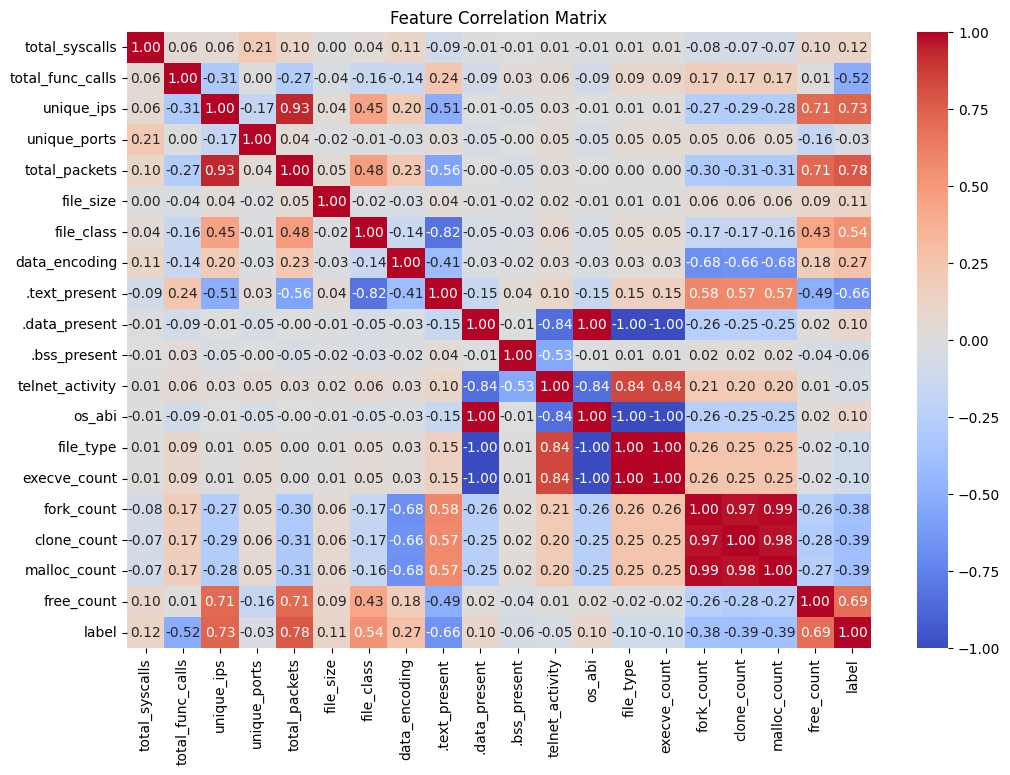

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
corr_matrix = df.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


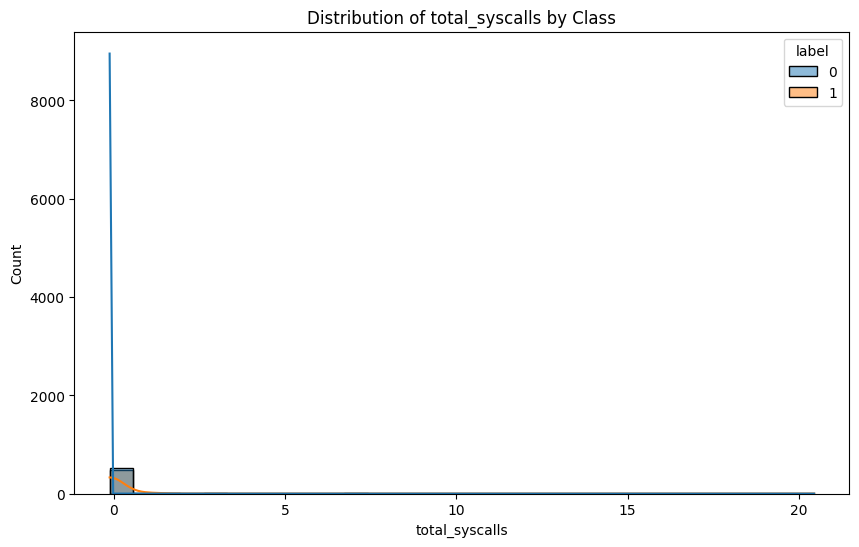

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


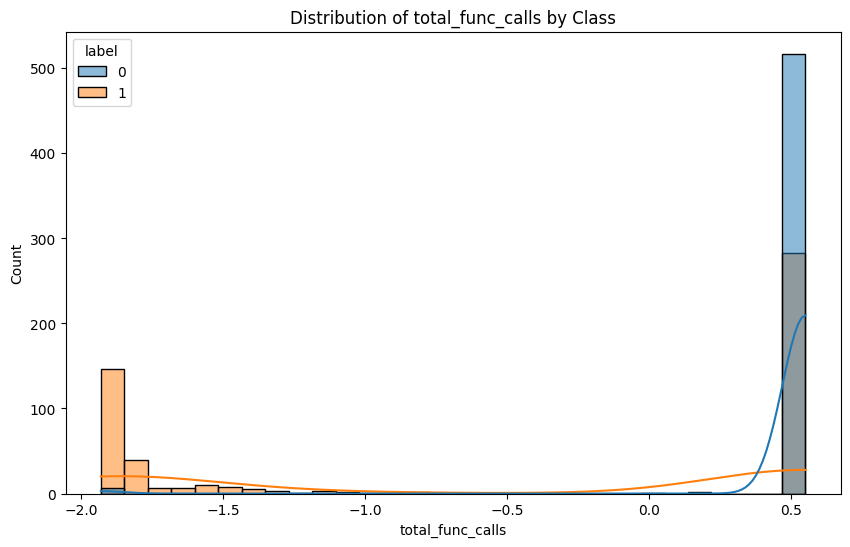

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


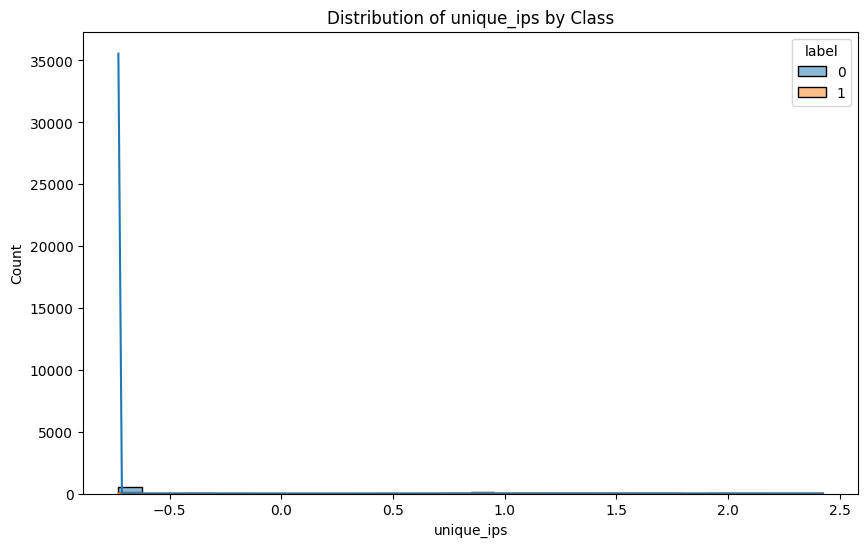

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


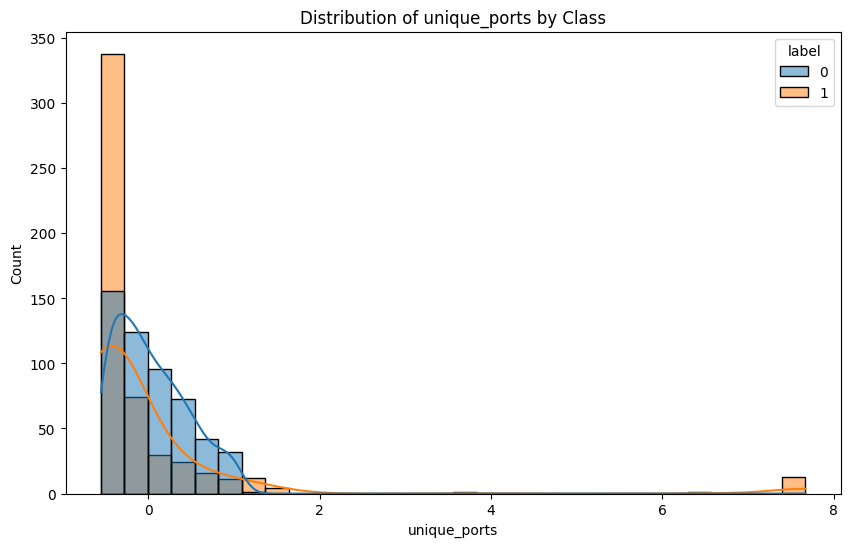

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


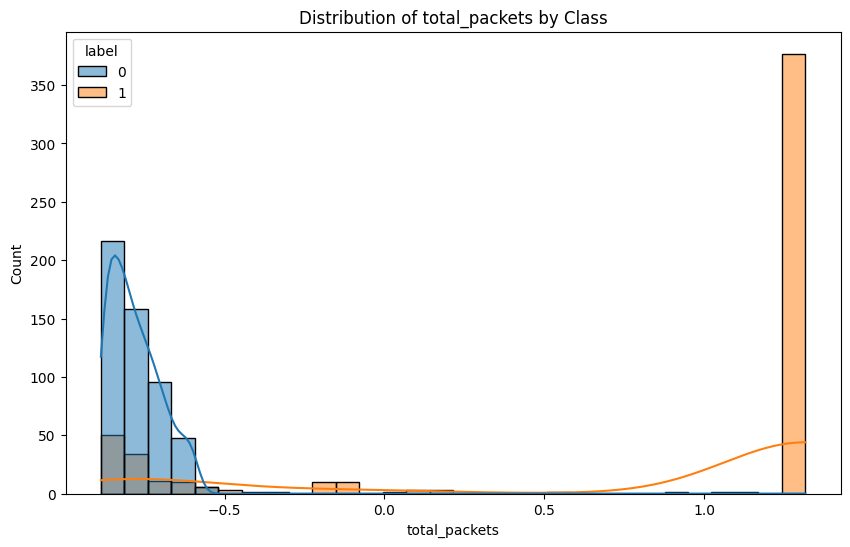

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


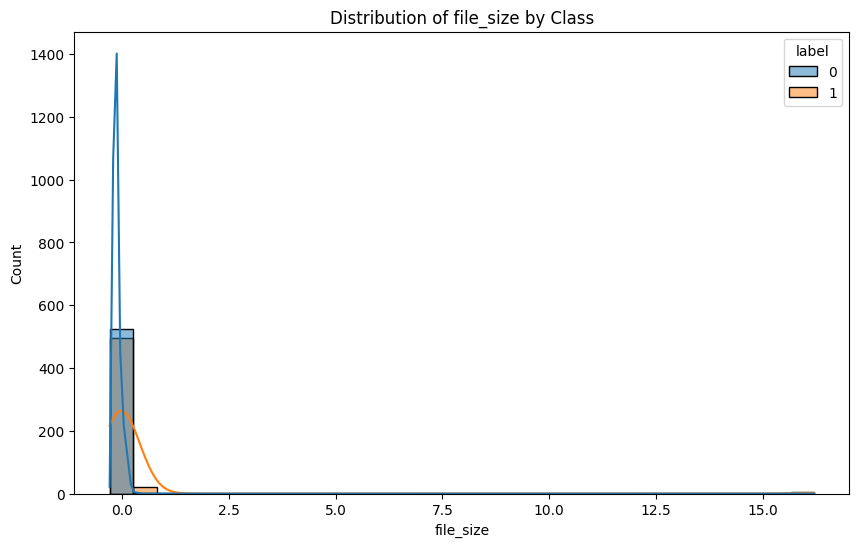

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


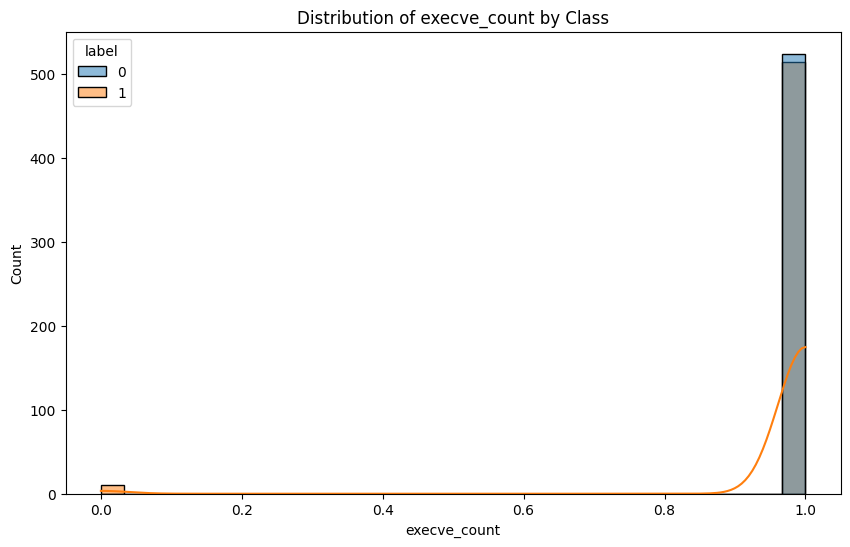

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


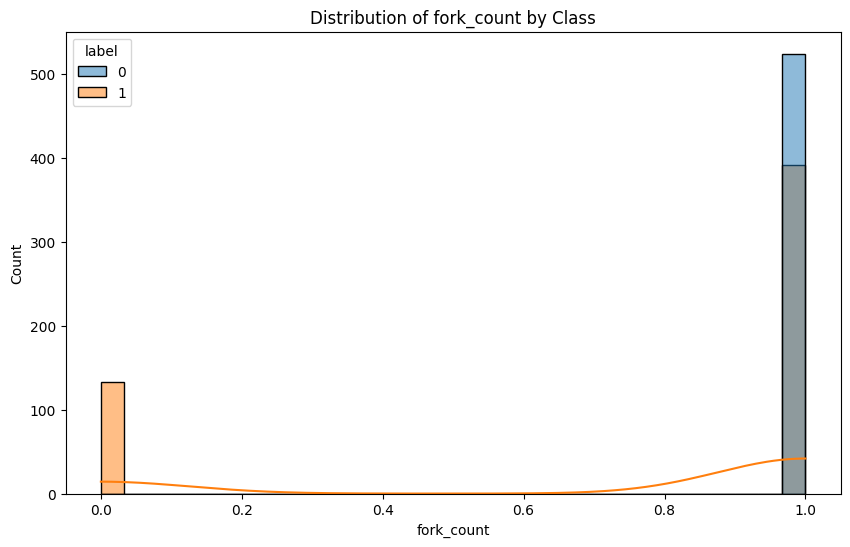

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


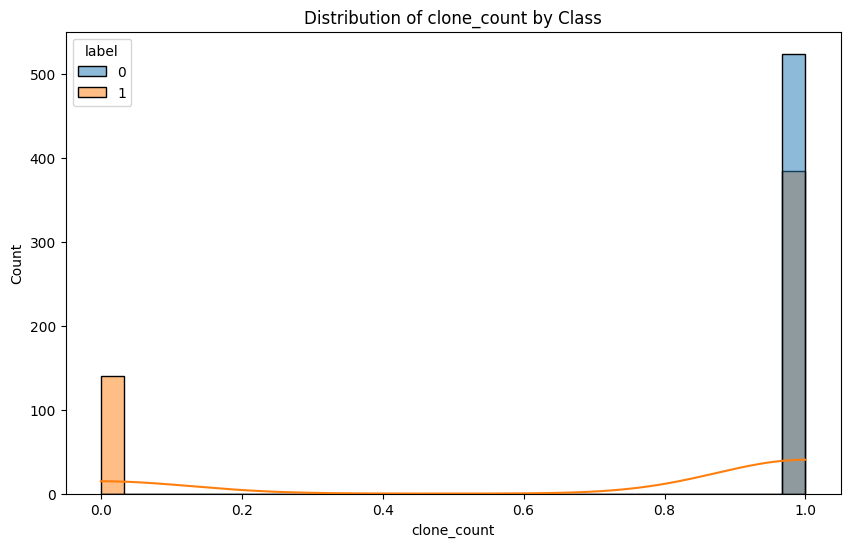

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


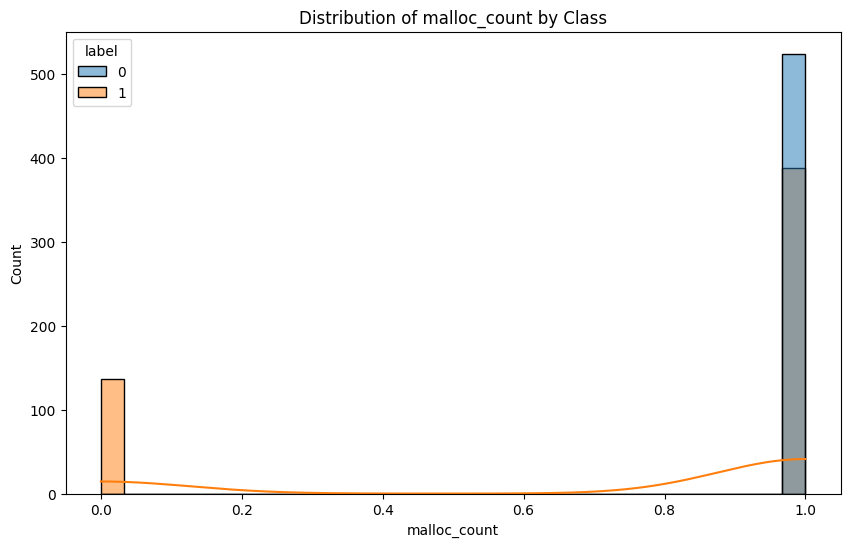

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


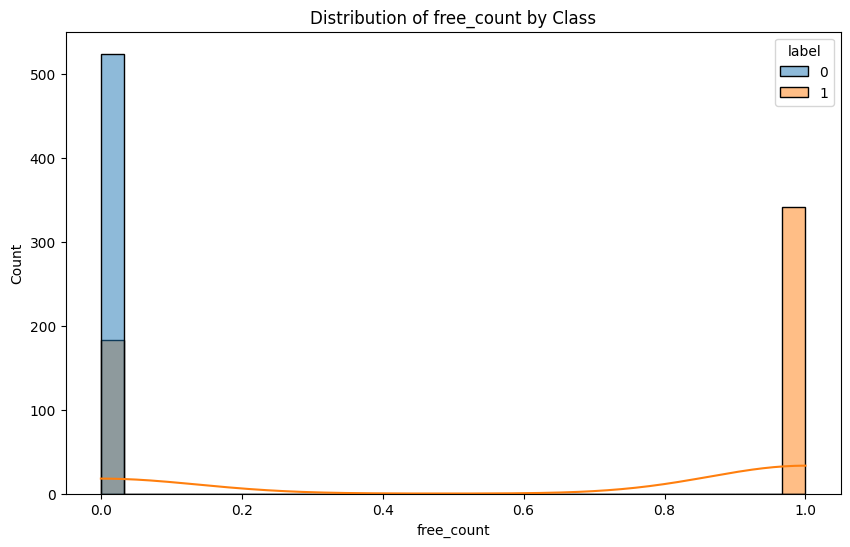

In [15]:
# List of numeric features for distribution analysis
numeric_features = [
    'total_syscalls', 'total_func_calls', 'unique_ips', 'unique_ports', 
    'total_packets', 'file_size', 'execve_count', 'fork_count', 
    'clone_count', 'malloc_count', 'free_count'
]

# Plotting distributions for each numeric feature
for col in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(df, x=col, hue='label', kde=True, bins=30)
    plt.title(f'Distribution of {col} by Class')
    plt.show()


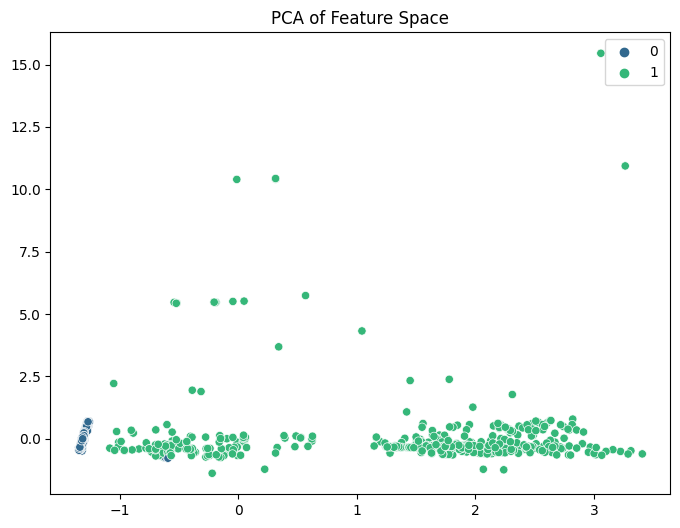

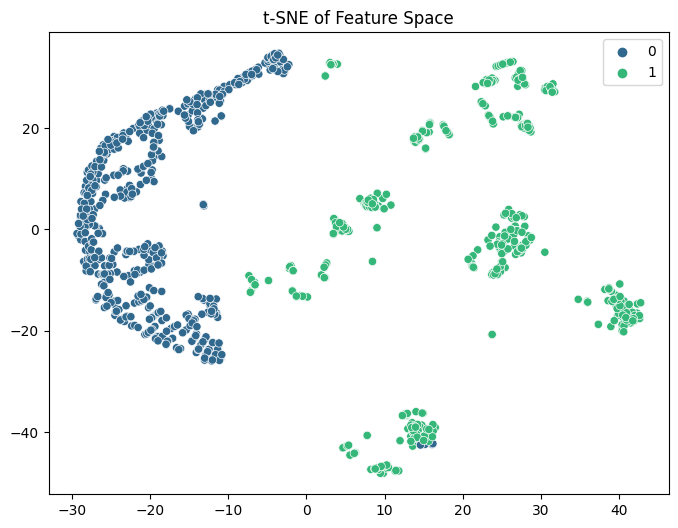

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load features and labels
X = np.load('/kaggle/working/feature_matrix.npy')
y = np.load('/kaggle/working/labels.npy')

# PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette="viridis")
plt.title("PCA of Feature Space")
plt.show()

# t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette="viridis")
plt.title("t-SNE of Feature Space")
plt.show()


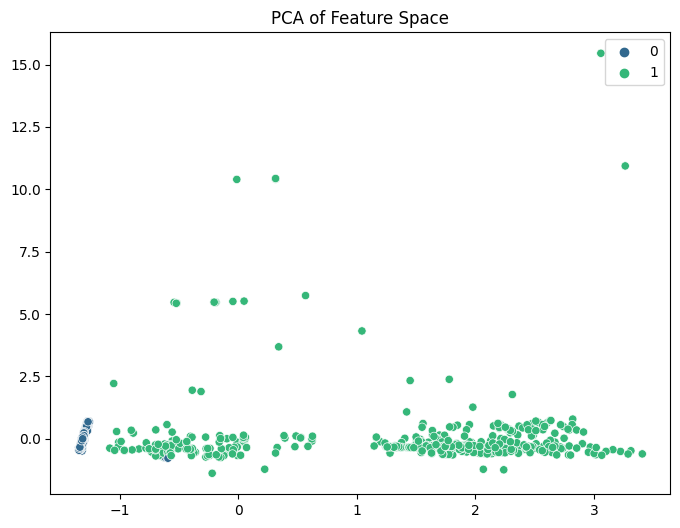

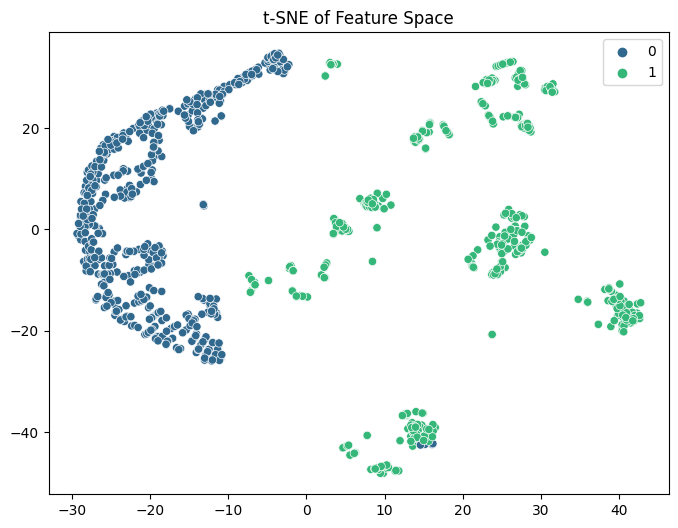

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


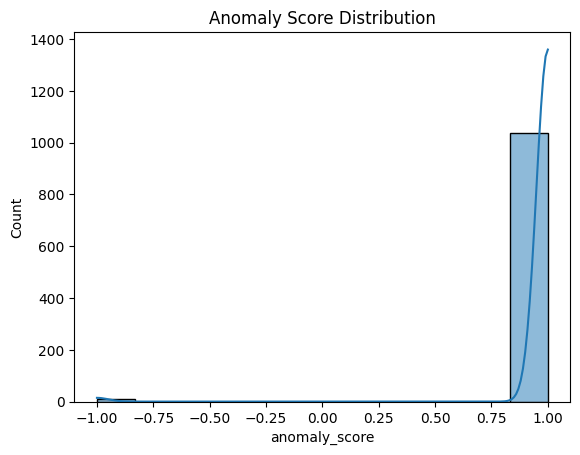

In [20]:
from sklearn.ensemble import IsolationForest

# Apply Isolation Forest for anomaly detection
iso_forest = IsolationForest(contamination=0.01)
df['anomaly_score'] = iso_forest.fit_predict(df.drop(columns=['label']))

# Plot the distribution of anomaly scores
sns.histplot(df['anomaly_score'], kde=True)
plt.title('Anomaly Score Distribution')
plt.show()


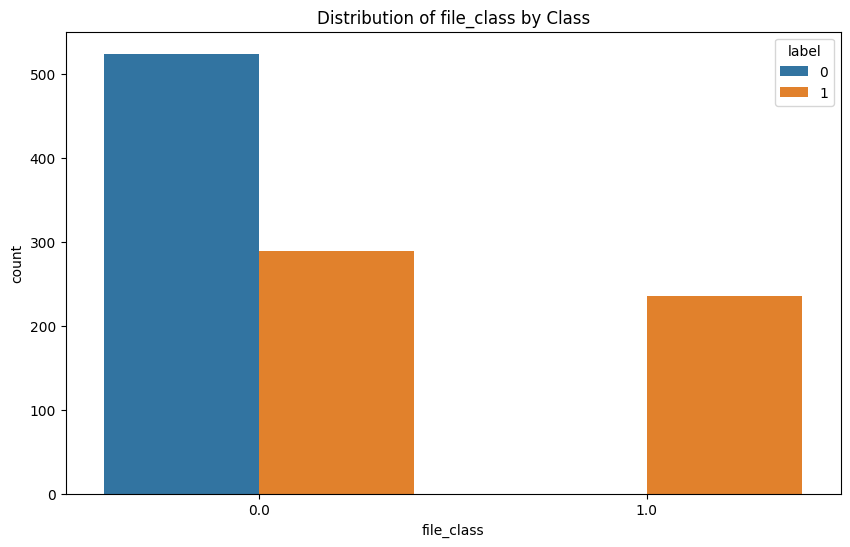

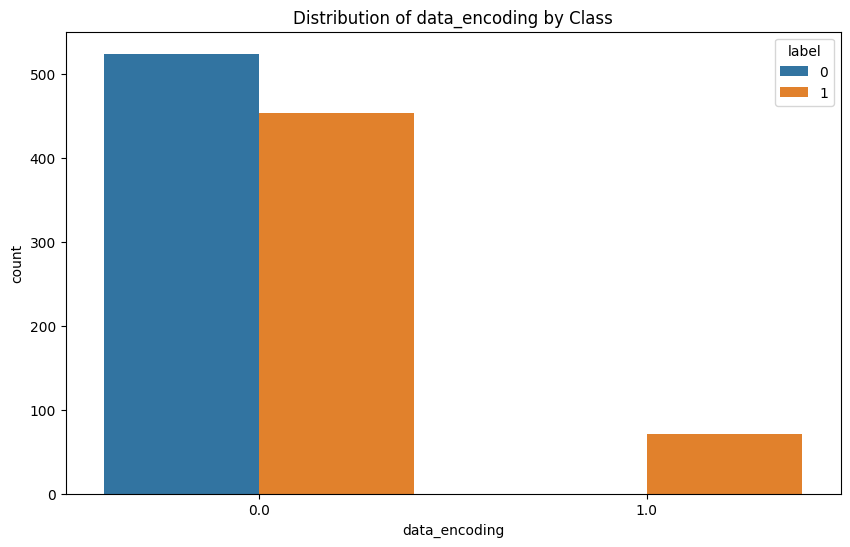

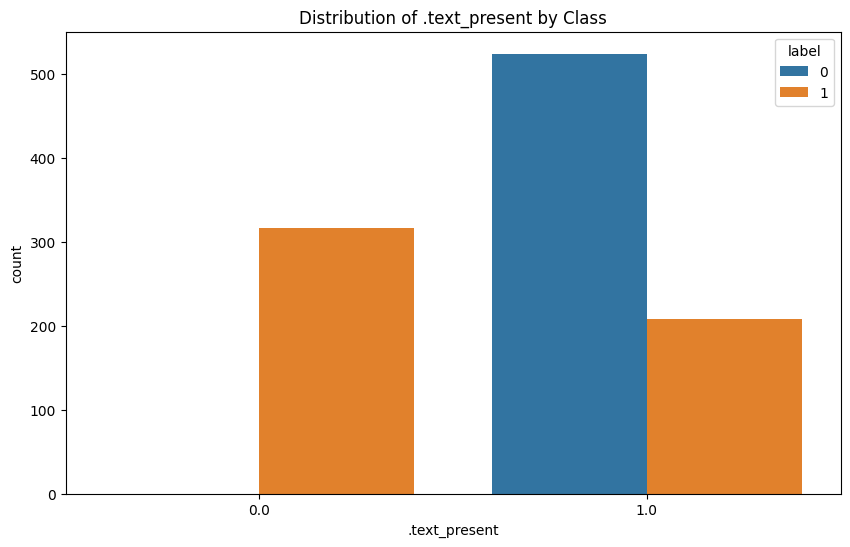

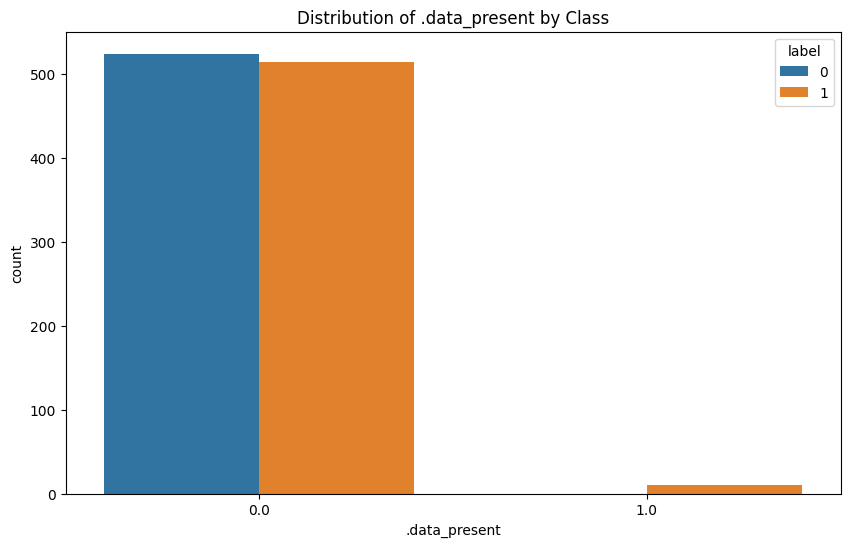

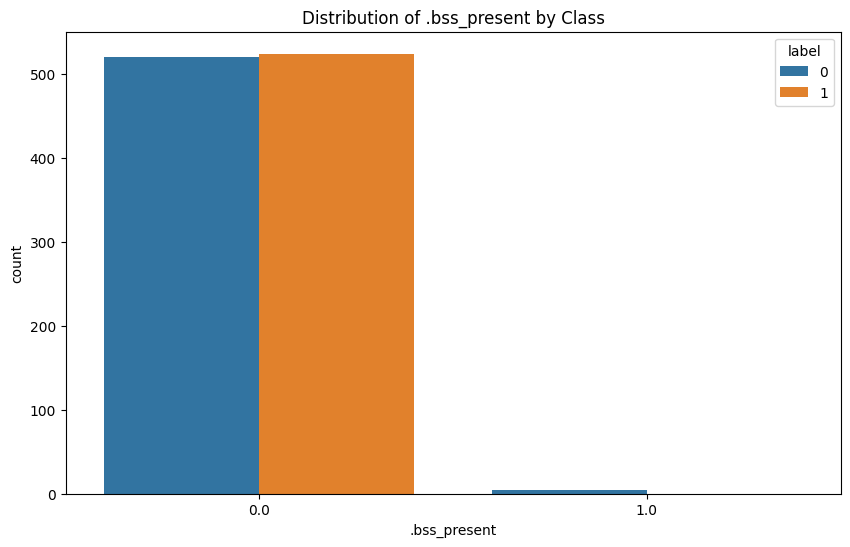

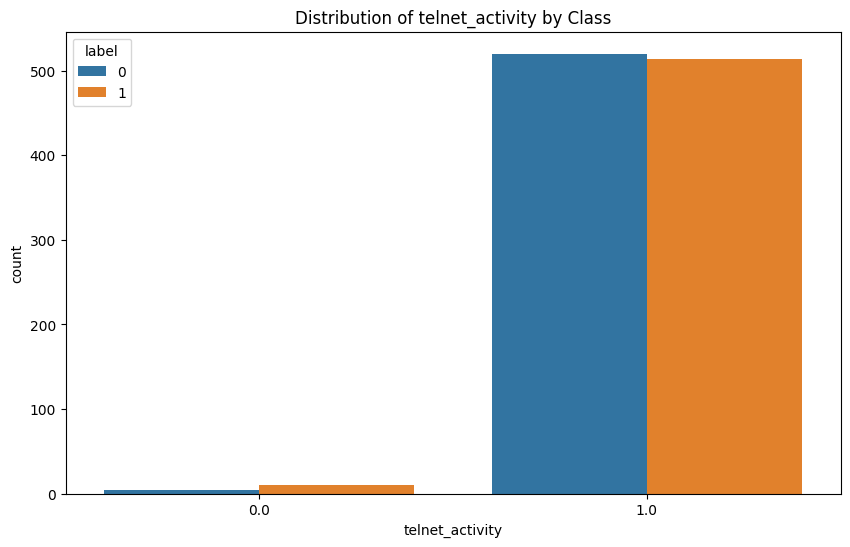

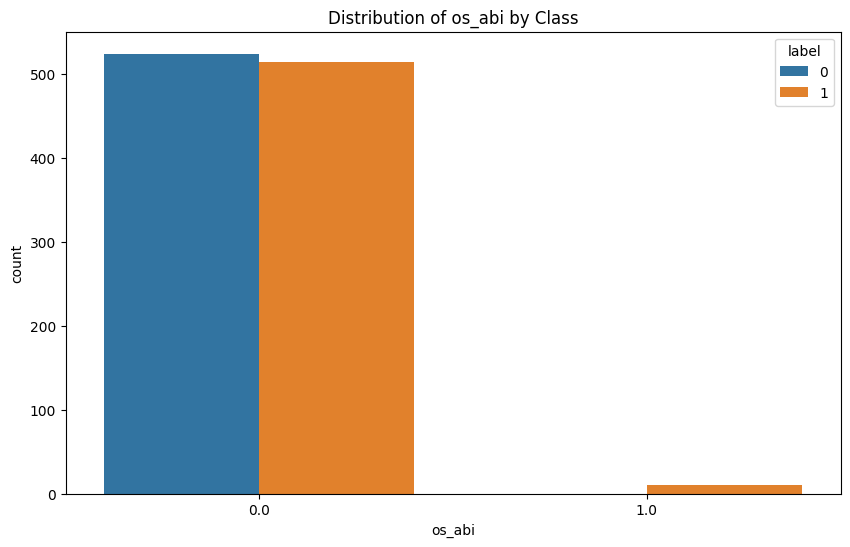

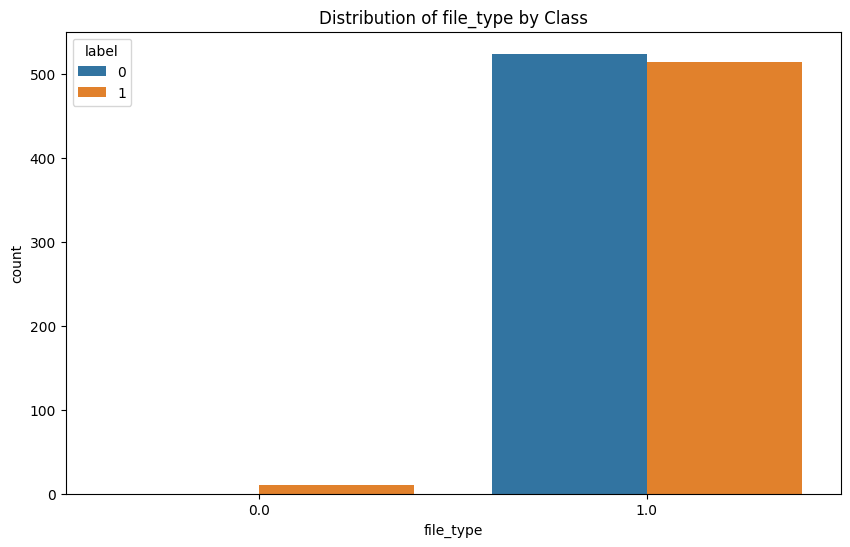

In [21]:
# Binary and categorical features
binary_categorical_features = [
    'file_class', 'data_encoding', '.text_present', 
    '.data_present', '.bss_present', 'telnet_activity', 
    'os_abi', 'file_type'
]

# Plotting distributions for binary and categorical features
for col in binary_categorical_features:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, hue='label', data=df)
    plt.title(f'Distribution of {col} by Class')
    plt.show()


In [22]:
# Convert timestamps to datetime format if necessary
df['creation_time'] = pd.to_datetime(df['creation_time'], unit='s')
df['modification_time'] = pd.to_datetime(df['modification_time'], unit='s')

# Plotting time-based patterns
plt.figure(figsize=(10, 6))
sns.histplot(df, x='creation_time', hue='label', kde=True)
plt.title('Distribution of Creation Time by Class')
plt.show()


KeyError: 'creation_time'

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


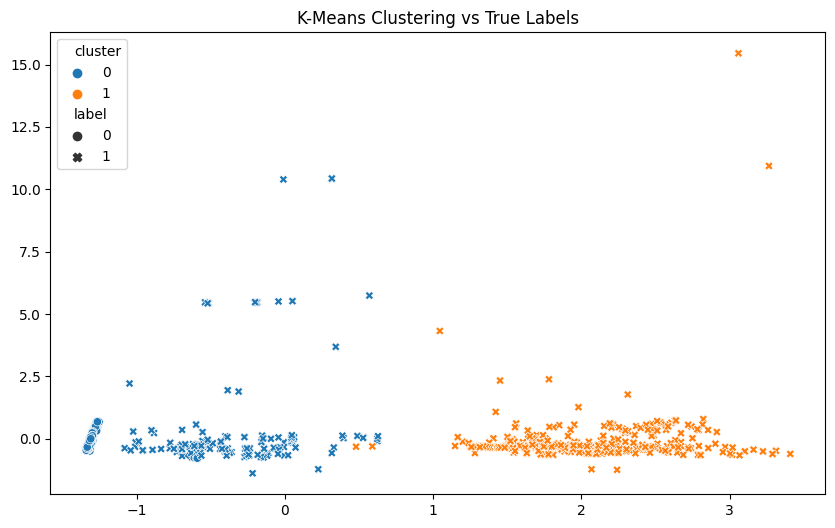

In [23]:
from sklearn.cluster import KMeans

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
df['cluster'] = kmeans.fit_predict(df.drop(columns=['label', 'anomaly_score']))

# Compare clusters with true labels using PCA plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df['cluster'], style=df['label'])
plt.title('K-Means Clustering vs True Labels')
plt.show()


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data
X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Neural Network": MLPClassifier(max_iter=1000)
}

#ADABoost

# Train and evaluate each model using cross-validation
results = {}
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    results[name] = cv_scores
    print(f"{name}: Mean Accuracy = {np.mean(cv_scores):.4f}, Std = {np.std(cv_scores):.4f}")


Logistic Regression: Mean Accuracy = 0.9893, Std = 0.0045
SVM: Mean Accuracy = 0.9905, Std = 0.0072
Random Forest: Mean Accuracy = 0.9976, Std = 0.0029
Gradient Boosting: Mean Accuracy = 0.9940, Std = 0.0092
KNN: Mean Accuracy = 0.9940, Std = 0.0000
Naive Bayes: Mean Accuracy = 0.9833, Std = 0.0070
Neural Network: Mean Accuracy = 0.9893, Std = 0.0070


In [27]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Set up GridSearchCV
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Output the best parameters and the corresponding score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")


Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score: 0.9976


In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Evaluate the best model (e.g., RandomForest) on the test set
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")


Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1 Score: 1.0000
Test ROC AUC: 1.0000
Confusion Matrix:
[[105   0]
 [  0 105]]


In [29]:
from sklearn.ensemble import StackingClassifier

# Example of stacking multiple models
estimators = [
    ('rf', RandomForestClassifier(n_estimators=200)),
    ('gb', GradientBoostingClassifier(n_estimators=200)),
    ('svc', SVC(probability=True))
]

stacking_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stacking_model.fit(X_train_scaled, y_train)

# Evaluate the stacking model
y_pred_stack = stacking_model.predict(X_test_scaled)
accuracy_stack = accuracy_score(y_test, y_pred_stack)
print(f"Stacking Model Accuracy: {accuracy_stack:.4f}")


Stacking Model Accuracy: 1.0000
